## Installation of FreeTrace

In [ ]:
!pip install FreeTrace
import FreeTrace.installation

## Load pacakges

In [49]:
!pip install requests ipykernel ipympl jupyter notebook ipython matplotlib ipywidgets
%matplotlib widget
import requests
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
from PIL import Image
from matplotlib.patches import Rectangle
from module.fileIO.DataLoad import read_multiple_csv
from module.preprocessing import preprocessing, func_to_minimise, pdf_cauchy_1mixture, cauchy_location
from module.visuailzation import trajectory_visualization
from FreeTrace import Tracking, Localization

## Sample video download

In [9]:
def download_file(url, save_path):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            with open(save_path, 'wb') as file:
                file.write(response.content)
            print(f"File downloaded successfully: {save_path}")
        else:
            print(f"Failed to download file. Status code: {response.status_code}")
    except Exception as e:
        print(f"Error: {e}")
        
fus = f"https://psilo.sorbonne-universite.fr/index.php/s/2YFgtzoctY5WfZW/download/sample1_mifibio.tiff"
h2b = f"https://psilo.sorbonne-universite.fr/index.php/s/xTRkLMPRj56ReW4/download/sample2_mifobio.tiff"
download_file(fus, f'./sample1_mifobio.tiff')
download_file(h2b, f'./sample2_mifobio.tiff')
if not os.path.exists('outputs'):
    os.mkdir('outputs')
if not os.path.exists('outputs/sample1'):
    os.mkdir('outputs/sample1')
if not os.path.exists('outputs/sample2'):
    os.mkdir('outputs/sample2')

File downloaded successfully: ./sample1_mifobio.tiff
File downloaded successfully: ./sample2_mifobio.tiff


# Requirements
FreeTrace requires Linux platform to infer fully the molecular trajectories.</br>
- CUDA accelerates the localisation of molecules from video if you have a NVIDIA GPU in your machine.</br>
- Cuda installation: [Nvidia Cuda installation](https://developer.nvidia.com/cuda-toolkit)</br>
  
You can run FreeTrace without a GPU; however, it'll be very slow if you try to infer the trajectories with fBm mode.</br>
In the case of high molecular density in a heterogeneous medium, we recommend running FreeTrace on a GPU-equipped machine for the best inference result.</br>

Github: https://github.com/JunwooParkSaribu/FreeTrace

# 1. Parameter settings
Below is the parameters of FreeTrace.</br>

In [4]:
"""
Path of input video and output results.
"""
video_name = 'sample1_mifobio.tiff'  # input video.tiff path.
output_dir = 'outputs/sample1'  # output path.


"""
Basic parameters.
"""
window_size = 7  # Length (pixel) of sliding window to localise molecules from video
threshold = 0.5  # Threshold factor to determine the existence of a molecule inside sliding windows, base thresholds are calculated with SNR of images.
cutoff = 3  # Minimum length of trajectory for the output.


"""
Advanced parameters.
"""
gpu_for_localization = True  # GPU acceleration of localisation if True, False otherwise.
realtime_localization = False  # Real-time visualisation of localisation if True, False otherwise.
save_localization_video = False  # Save the visualised localisation in tiff format (requires enough RAM).

fBm_mode = True  # Tracking under fBm if True (slow). Otherwise, FreeTrace infers the trajectories under classical Brownian motion.
jump_threshold = None  # Maximum jump distance of molecules for 1 frame. If None, FreeTrace estimates it automatically with GMM.
graph_depth = 3  # Number of frames for the inference of trajectories at each step, between 1 and 5 inclusive. A higher number will slow down the speed.
realtime_tracking = False  # Real-time visualisation of tracking if True, False otherwise.
save_tracking_video = False  # Save the visualised trajectories in tiff format (requires enough RAM).

# 2. Localization

- Run the localization of molecules from video with pre-difined parameters above.</br>
- Localization.run_process() returns True if it finishes successfully.

In [6]:
success = Localization.run_process(input_video_path=video_name,
                                     output_path=output_dir,
                                     window_size=window_size,
                                     threshold=threshold,
                                     gpu_on=gpu_for_localization,
                                     save_video=save_localization_video,
                                     realtime_visualization=realtime_localization,
                                     verbose=1)

2025-10-07 15:51:46.938961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-07 15:51:47.001921: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-07 15:51:47.020162: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-07 15:51:47.159331: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-07 15:51:48.317994: W tensorflow/compiler/tf2


******************************** OPTIONS *****************************************
*********                Cuda: O, Localization with GPU.                 *********
**********************************************************************************



I0000 00:00:1759845109.134188  182190 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759845109.300878  182190 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759845109.301000  182190 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
Localization: 100%|██████████████████████████████████████████████████████████████| 2500/2500 [00:26<00:00, 93.53frame/s]


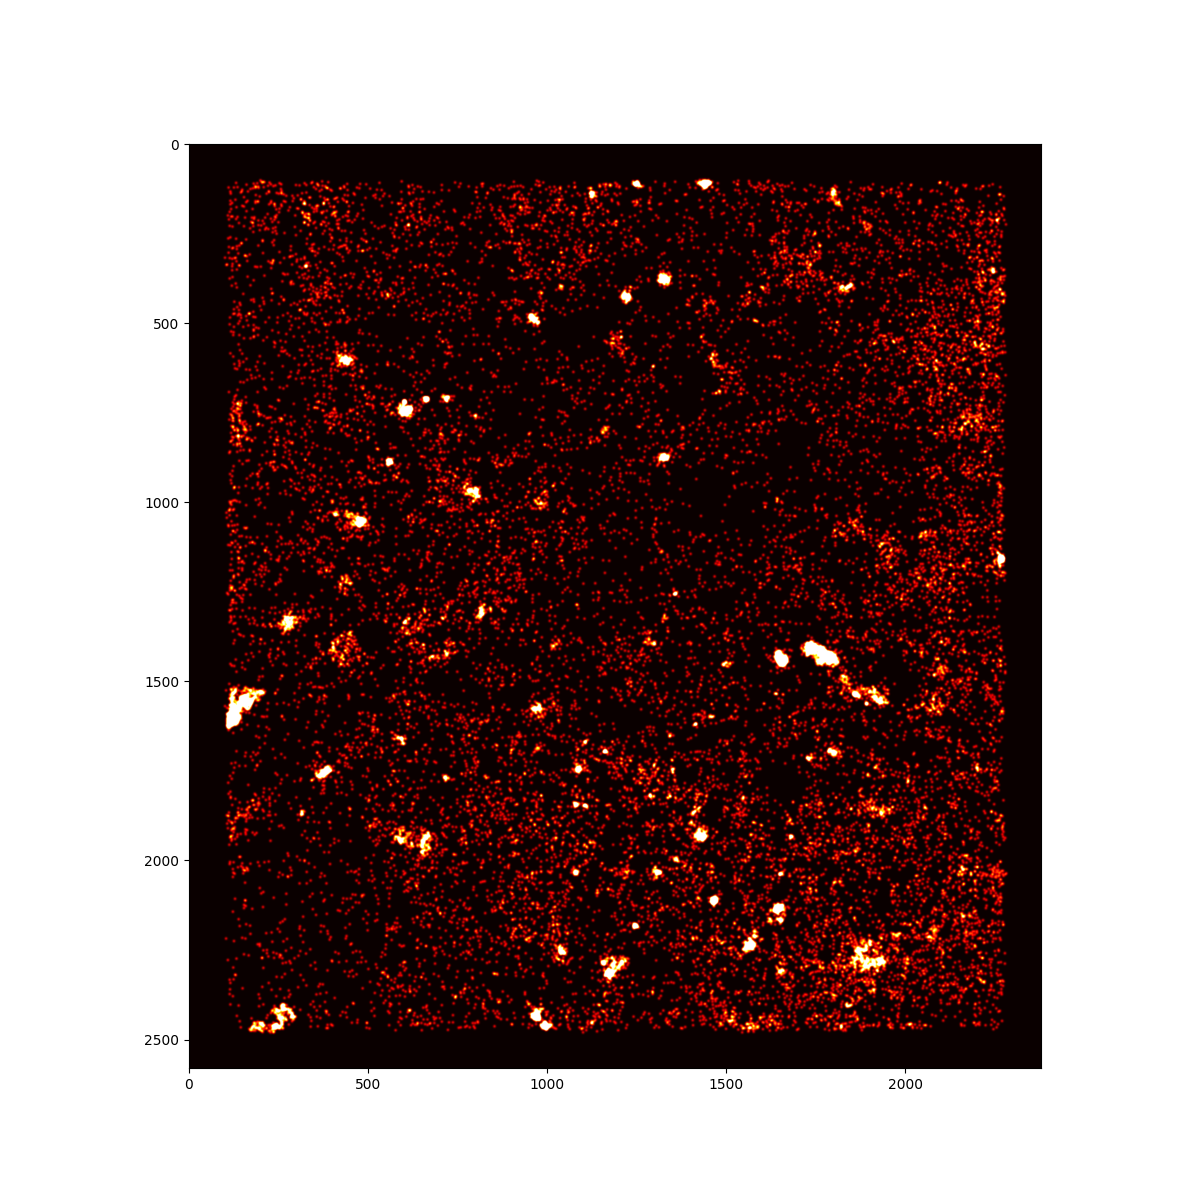

In [7]:
plt.close('all')
plt.figure(figsize=(10, 10))
plt.imshow(np.asarray(Image.open(f"{output_dir}/{video_name.split('.tif')[0]}_loc_2d_density.png")))
plt.show()

# 3. Trajectory inference

- Run the tracking of localized molecules from video and localization results, with pre-defined parameters above.</br>
- Tracking.run_process() returns True if it finishes successfully.

In [ ]:
success = Tracking.run_process(input_video_path=video_name,
                             output_path=output_dir,
                             graph_depth=graph_depth,
                             cutoff=cutoff,
                             jump_threshold=jump_threshold,
                             gpu_on=fBm_mode,
                             save_video=save_tracking_video,
                             realtime_visualization=realtime_tracking,
                             verbose=1)

2025-10-07 15:52:48.107716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-07 15:52:48.120377: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-07 15:52:48.124256: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-07 15:52:48.136411: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-07 15:52:48.932883: W tensorflow/compiler/tf2


******************************** OPTIONS *****************************************
*********       Tensorflow: O, Tracking with GPU if fBm_mode is ON.      *********
**********************************************************************************



I0000 00:00:1759845169.559050  182358 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759845169.705439  182358 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759845169.705533  182358 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759845170.659685  182358 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759845170.659775  182358 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Mean nb of particles per frame: 9.57 particles/frame


Tracking:   0%|                                                                             | 0/2501 [00:00<?, ?frame/s]/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Tracking:   0%|▏                                                                    | 6/2501 [00:00<01:45, 23.72frame/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1759845191.156560  182442 service.cc:146] XLA service 0x240b5de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759845191.156595  182442 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-10-07 15:53:11.206422: I external/

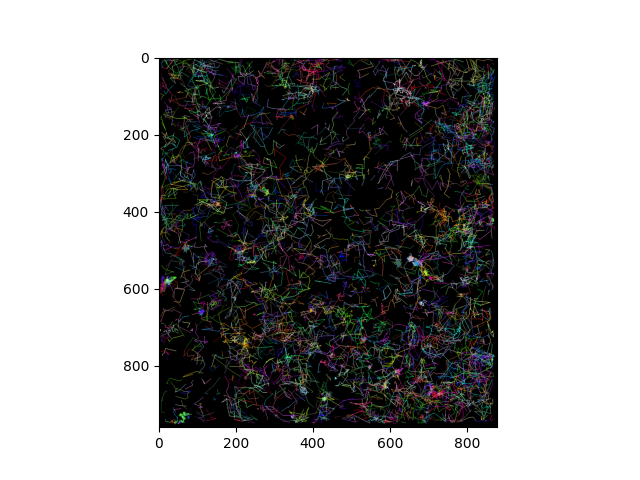

In [12]:
plt.close('all')
plt.figure()
plt.imshow(np.asarray(Image.open(f"{output_dir}/{video_name.split('.tif')[0]}_traces.png")))
plt.show()

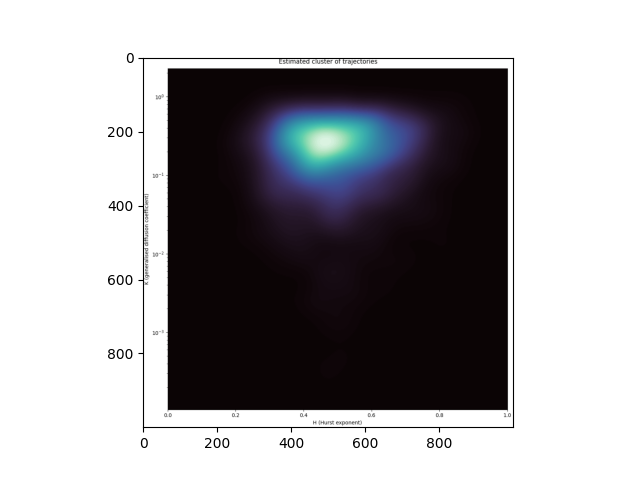

In [13]:
plt.close('all')
plt.figure()
plt.imshow(np.asarray(Image.open(f"{output_dir}/{video_name.split('.tif')[0]}_diffusion_distribution.png")))
plt.show()

# 4. Load trajectory data

In [65]:
"""
Options for the analysis, processing of the data.
"""
FOLDER = output_dir  # The folder containing result .h5 files, condition2 contains samples of simulated fBm trajectories transitioning its states.
PIXELMICRONS = 1  # length of pixel in micrometer. (0.16 -> the length of each pixel is 0.16 micrometer, it varies depending on microscopy.)
FRAMERATE = 1  # exposure time of video for each frame in seconds. (0.01 corresponds to the 10ms) 
CUTOFF = [3, 9999]   # mininum length of trajectory to consider


"""
Preprocessing generates 7 data.
@params: data folder path, pixel microns, frame rate, cutoff
@output: DataFrame, DataFrame, ndarray, networkx graph, DataFrame, DataFrame, list, dict

Preprocessing includes the following steps.
1. Exclude the trajectory where the length is shorter than CUTOFF.
2. Convert from pixel unit to micrometre unit with PIXELMICRONS and FRAMERATE.
3. Generate 5 DataFrames. 
If you want to calculate tamsd, set it as True. It is off in default since tamsd takes time to calculate it.
"""

original_data = read_multiple_csv(path=FOLDER) # all trajectories
#original_data = original_data[(original_data['K'] > 0.30)] # group 1
#original_data = original_data[(original_data['H'] < 0.42) & (original_data['K'] < 0.01)] # group 2
#original_data = original_data[(original_data['H'] > 0.42) & (original_data['K'] < 0.01)] # group 3


analysis_data1, analysis_data2, analysis_data3, analysis_data4, analysis_data5, _, _, _, tamsd, _, _ \
    = preprocessing(data=original_data, pixelmicrons=PIXELMICRONS, framerate=FRAMERATE, cutoff=CUTOFF, div_time_gap=True, tamsd_calcul=True)
trajectory_image, legend_patch, cmap_for_graph, cmap_for_plot = trajectory_visualization(original_data, analysis_data1, CUTOFF, PIXELMICRONS, resolution_multiplier=40, roi='')


** Computing of Ensemble-averaged TAMSD takes a few minutes **


Analysis: 100%|██████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 481.80trajectory/s]
/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


** preprocessing finished **
** visualizing trajectories... **


Visualization: 100%|████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 1367.71trajectory/s]


From here, we process the data to create plots or print results.<br>
Data is stored as<br>
1. analysis_data1: (DataFrame: contains data of mean_jump_distance, K, H, duration, traj_id)<br>
2. analysis_data2: (DataFrame: contains data of 2D displacements)<br>
3. analysis_data3: (DataFrame: contains data of angles)<br>
4. analysis_data4: (DataFrame: contains data of 1D displacements)<br>
5. analysis_data5: (DataFrame: contains data of Ratios)<br>
6. tamsd: (DataFrame: contains ensemble-averaged tamsd for each state.) <br>
<br>
Units: <br>
K: generalised diffusion coefficient, px^2 / sec^2H.<br>
H: Husrt exponent (2 x anomalous diffusion exponent), real number between 0 and 1, exclusive.<br>

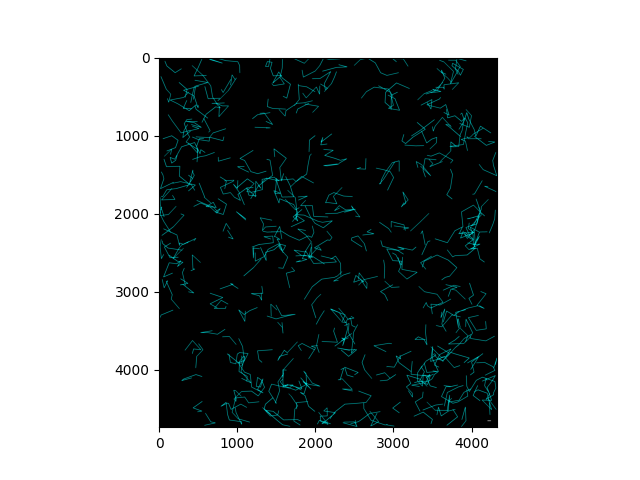

In [66]:
#p0: trajectory image.
plt.close('all')
plt.figure(f'p0')
plt.imshow(trajectory_image)
plt.show()

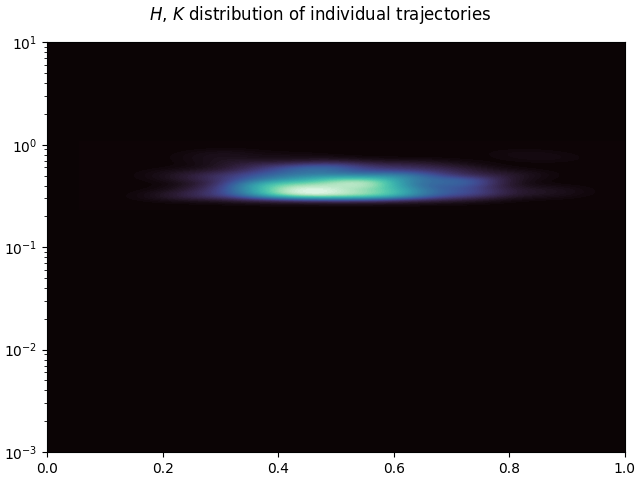

In [67]:
#p1: Distribution of H(x-axis) and K(y-axis)
plt.close('all')
fig, axs = plt.subplots(1, 1, layout='constrained', num=f'p1')
colormap = sns.color_palette("mako", as_cmap=True)
axs.add_patch(Rectangle((0, -100), 1.0, 1000, ec='none', fc=colormap(0), zorder=0))
sns.kdeplot(
    data=analysis_data1, x="H", y="K", fill=True, ax=axs, thresh=0, levels=100, cmap=colormap, log_scale=(False, True), bw_adjust=1.0,
)
axs.set_yscale('log')
axs.set_xlim([0.0, 1.0])
axs.set_ylim([10**-3, 10**1])
axs.set(xlabel=None, ylabel=None)
fig.suptitle(r'$H$, $K$ distribution of individual trajectories')
plt.show()

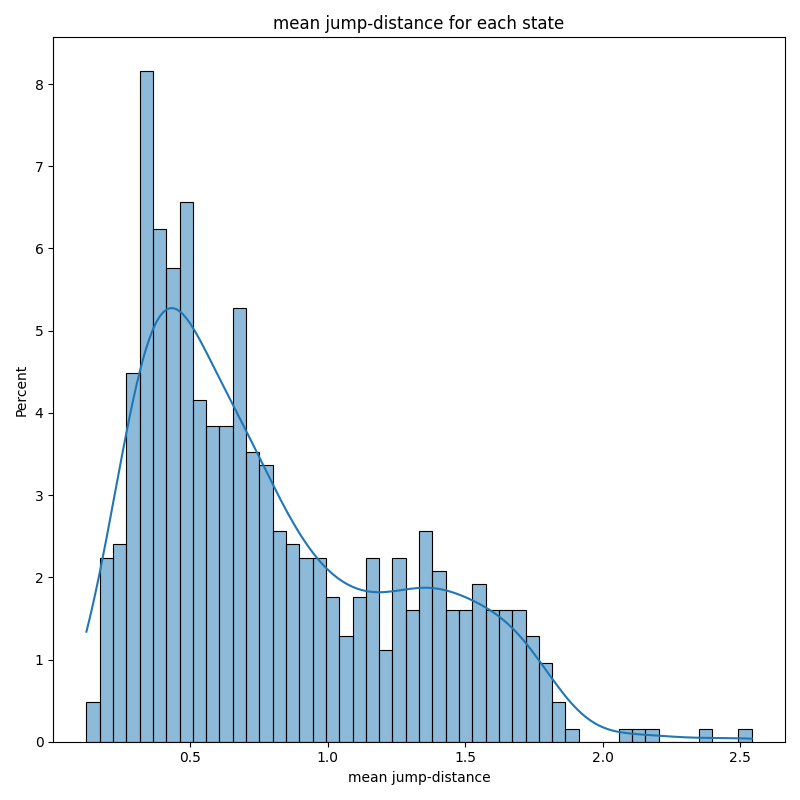

In [38]:
#p2: Histogram with kde(kernel density estimation) plot of mean jump distances.
plt.close('all')
plt.figure(f'p2', figsize=(8, 8))
p1 = sns.histplot(analysis_data1, x=f'mean_jump_d', stat='percent', bins=50, kde=True)
p1.set_xlabel(r'mean jump-distance')
p1.set_title(f'mean jump-distance for each state')
plt.tight_layout()
plt.show()

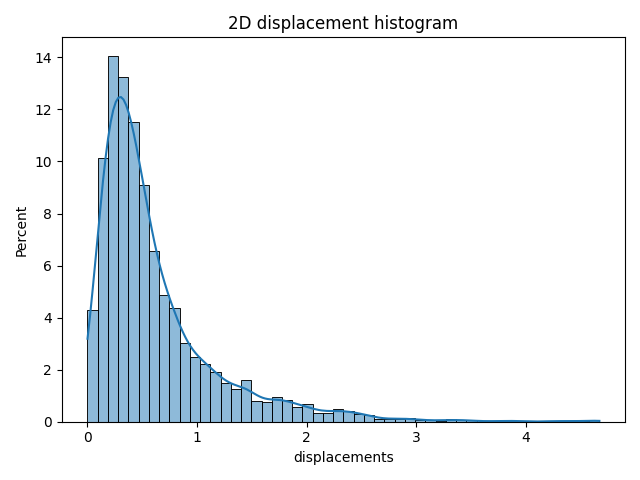

In [39]:
#p3: 2D Displacement histogram
plt.close('all')
fig, axs = plt.subplots(num='p3')
p5 = sns.histplot(data=analysis_data2, x='displacements', stat='percent', bins=50, kde=True)
p5.set_title(f'2D displacement histogram')
plt.tight_layout()
plt.show()

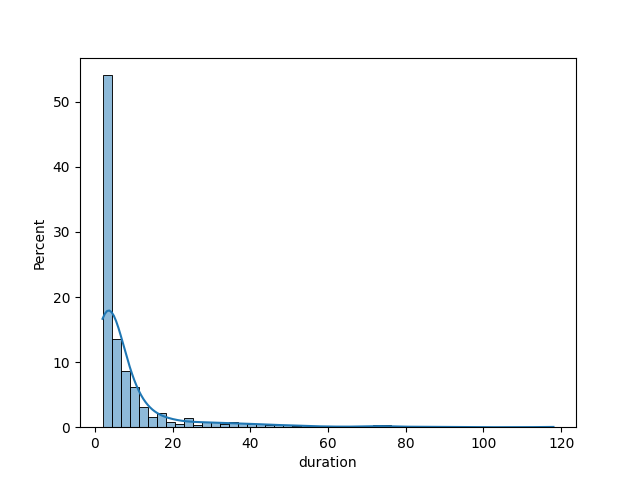

In [40]:
#p4: trajectory length(sec) histogram
plt.close('all')
fig, axs = plt.subplots(num=f'p4')
p6 = sns.histplot(data=analysis_data1, x='duration', stat='percent', bins=50, kde=True)
plt.show()

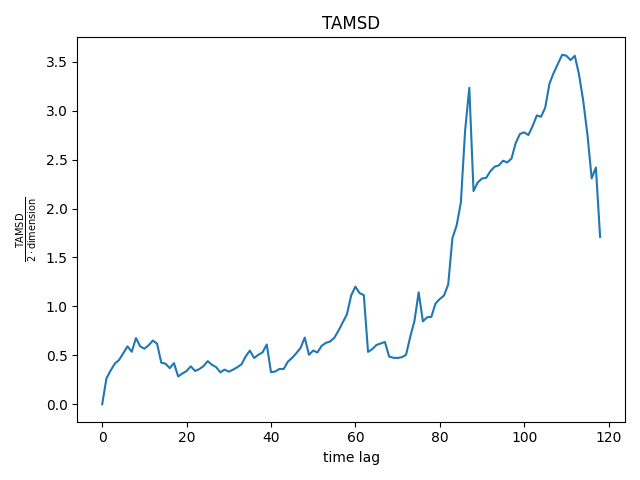

In [41]:
#p5: TAMSD
plt.close('all')
plt.figure(f'p5')
p8 = sns.lineplot(data=tamsd, x=tamsd['time'], y=tamsd['mean'])
p8.set_title(f'TAMSD')
p8.set_xlabel(r'time lag')
p8.set_ylabel(r'$\frac{\text{TAMSD}}{\text{2} \cdot \text{dimension}}$')
plt.tight_layout()
plt.show()

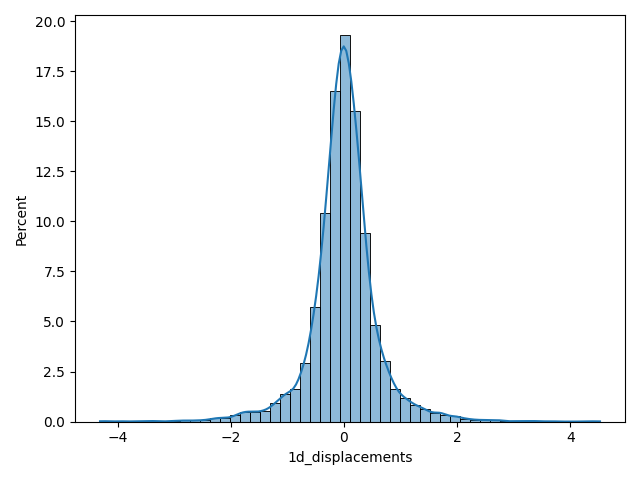

In [42]:
#p6: 1D displacements histogram
plt.close('all')
plt.figure(num=f'p6')
p6 = sns.histplot(data=analysis_data4, x='1d_displacements', stat='percent', bins=50, kde=True)
plt.tight_layout()
plt.show()

0.16798447842800596 9.961838813809386e-05


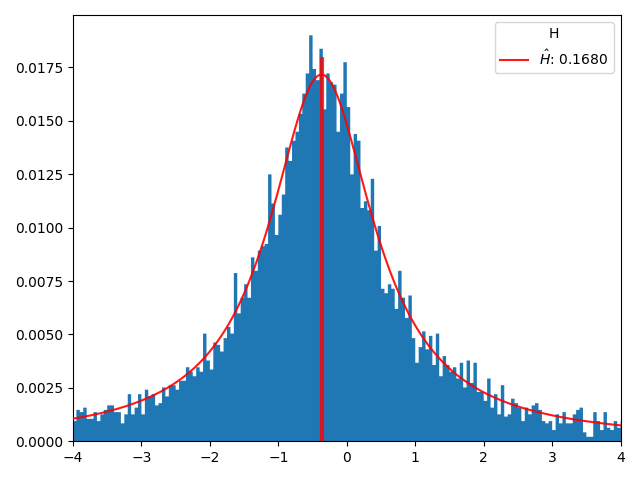

In [57]:
plt.close('all')
plt.figure(num=f'p7')
vline_ymax = 0.018
hist_bins = np.arange(-1000, 1000, 0.05)
target = analysis_data5['ratios'].to_numpy() 
hist, bin_edges = np.histogram(target, bins=hist_bins, density=False)
plt.hist(bin_edges[:-1], bin_edges, weights=hist/np.sum(hist), histtype='stepfilled', zorder=0, linewidth=2)
xs = hist_bins[:-1] + (hist_bins[1] - hist_bins[0])/2
cons = ({'type': 'ineq', 'fun': lambda k:  k[2] - 0.2},
        #{'type': 'eq', 'fun': lambda k:  k[0] + k[1] + k[2] - 1},
        )
res1 = minimize(func_to_minimise, x0=[0.5, 0.1], args=(pdf_cauchy_1mixture, xs, hist/np.sum(hist)), 
                method='trust-constr',
                #constraints=cons, 
                bounds=((1e-6, 0.9999), (1e-6, None),),
                )
params, residual = res1.x, res1.fun
print(params[0], residual)
plt.vlines(cauchy_location(params[0]), ymin=0, ymax=vline_ymax, colors='red', alpha=0.8, zorder=1, linewidth=3)
plt.plot(xs, pdf_cauchy_1mixture(xs, *params), c='red',
            label=r'$\hat{H}$: %5.4f' % params[0], alpha=0.9, zorder=20)
plt.xlim([-4, 4])
plt.legend(title=r'H', loc='upper right')
plt.tight_layout()
plt.show()